In [1]:
import itertools
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

/var/folders/w8/3scllvl903gf1z2yz14c0ztc0000gp/T/ipykernel_21494/1244681024.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Introduction
In this notebook, I import the training and test data and then systematically analyse the different variables. Some of the variables require no processing, others need a bit of cleaning. Some data I eventually thought wasn't worth including in the training model. Finally, I export the cleaned data to a csv file.

### Data Dictionary

<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>

### Variable Notes

**pclass**: A proxy for socio-economic status (SES)\
1st = Upper\
2nd = Middle\
3rd = Lower

**age**: Age is fractional if less than 1.\
If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...\
Sibling = brother, sister, stepbrother, stepsister\
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: 
The dataset defines family relations in this way...\
Parent = mother, father\
Child = daughter, son, stepdaughter, stepson\
Some children travelled only with a nanny, therefore parch=0 for them.

## Import Data

Import the training and test data. We will also create another dataframe, concatenating the training and test dataset. This will be used to compare distribution over data columns in both sets.

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
def join(train, test):
    return pd.concat([train, test], keys=["Train", "Test"], names=["Set"])

In [3]:
train.to_csv(os.getcwd() + "/data/train.csv", index = False)
test.to_csv(os.getcwd() + "/data/test.csv",  index = False)

In [8]:
color_set1 = sb.color_palette("muted")[0:2]
color_set2 = sb.color_palette("muted")[2:4]
args = {"hue":"Survived", "multiple":"dodge", "shrink":0.9, "palette":color_set1}
args_kde = {"hue":"Survived", "multiple":"layer", "palette":color_set1}
args_discrete = {"hue":"Survived", "multiple":"dodge", "discrete":True, "shrink":0.9, "palette":color_set1}
args_joined = {"hue":"Set", "multiple":"dodge", "discrete":True, "shrink":0.9, "palette":color_set2}

In [9]:
# what do the data rows typically look like?
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [103]:
# this might be useful later to split the data 
survived_idxs = train["Survived"] == 1

## Sex

Sex seems to be a very good predictor of survival with proportionally far more females surviving than men.

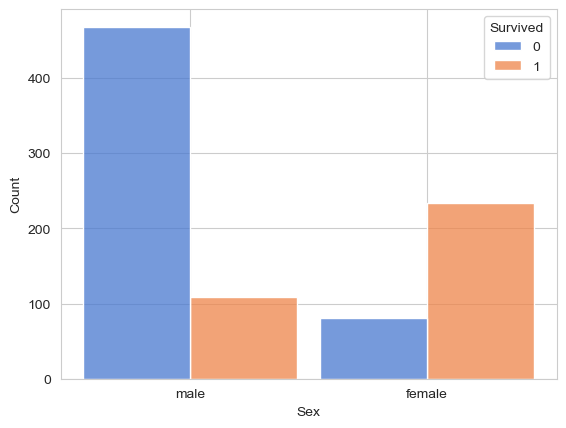

In [11]:
sb.set_style("whitegrid")
sb.histplot(
    data=train,
    x="Sex", **args_discrete
)

plt.show()

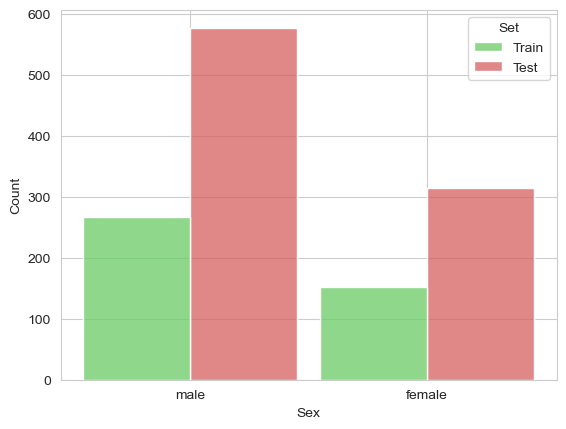

In [12]:
sb.histplot(data=join(test, train), x="Sex", **args_joined)
plt.show()

## Embarked

We see that the embarkation point has a large effect on survival rate. Those passengers who embarked from "Q" and "S" have a greater chance of survival. The distribution of "Embarked" is similar for the training and test sets. 

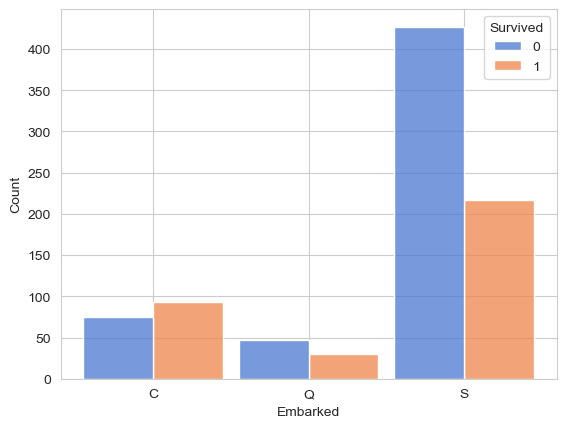

In [13]:
sb.histplot(data=train.sort_values("Embarked"), x="Embarked", **args_discrete)
plt.show()

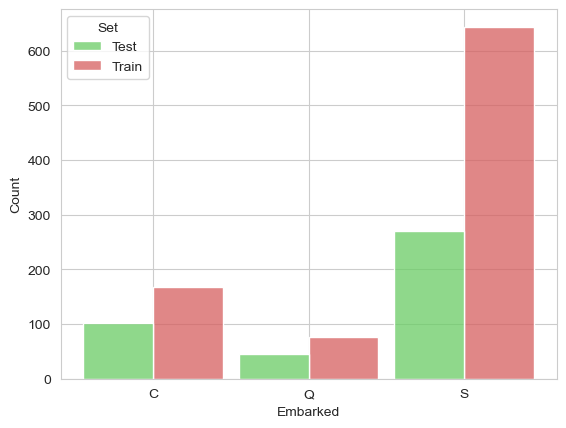

In [14]:
sb.histplot(data=join(train, test).sort_values("Embarked"),
            x="Embarked", **args_joined)
plt.show()

## Age

In [15]:
print("Missing values: ", train["Age"].isna().sum())
print("Number of unique values: ", len(train["Age"].dropna().unique()))
print(train["Age"].describe())

Missing values:  177
Number of unique values:  88
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


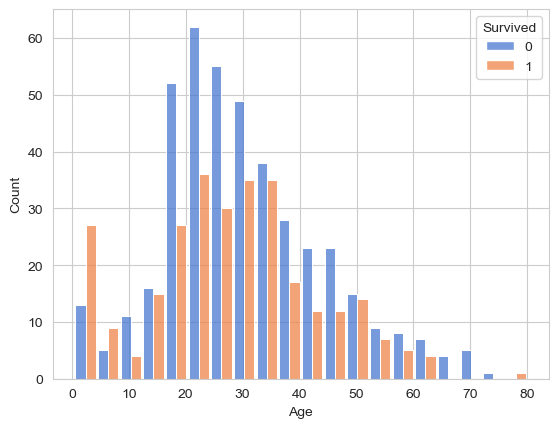

In [16]:
sb.histplot(data=train, x="Age", **args)
plt.show()

Age also seems to be strongly effect survival. It becomes a bit clearer in the kdeplotbelow. 
We see far greater survival rates for ages under 5. Ages 20-30 have a low survival rate. Survival rate seems 
to settle above this age range.

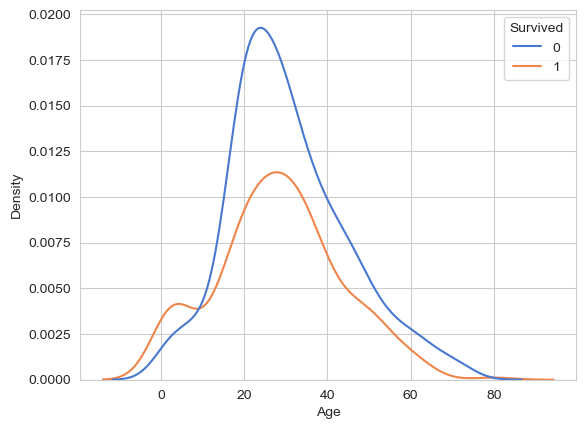

In [17]:
sb.kdeplot(data=train, x="Age", **args_kde)
plt.show()

## Ticket Class

In [18]:
print("Missing values: ", train["Pclass"].isna().sum())
print("Unique values: ", train["Pclass"].dropna().unique())
print(test["Pclass"].describe())

Missing values:  0
Unique values:  [3 1 2]
count    418.000000
mean       2.265550
std        0.841838
min        1.000000
25%        1.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64


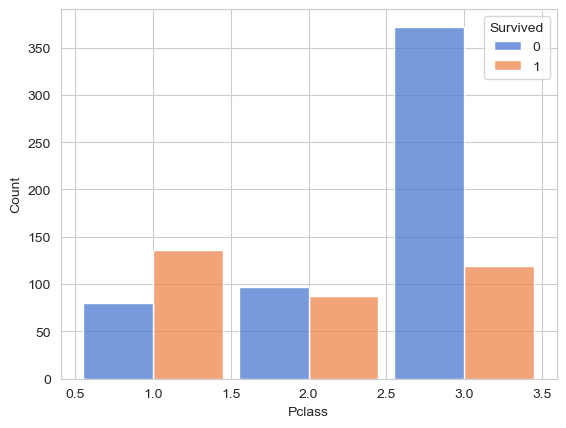

In [19]:
sb.histplot(data=train.sort_values("Pclass"), x="Pclass",
            **args_discrete)
plt.show()

Ticket class correlates strongly with survival rate. 

## Cabin

In [20]:
print("Missing values: ", train["Cabin"].isna().sum())
print(train["Cabin"].describe())

Missing values:  687
count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object


Lets look at an example of the cabin names

There are a lot of passenger without cabins. Perhaps the very absence of a cabin tells us something about 
the chance of survival? Let's have a look...

In [21]:
has_cabin = [0 if x is np.nan else 1 for x in train["Cabin"]]
has_cabin_test = [0 if x is np.nan else 1 for x in test["Cabin"]]
train["Has Cabin"] = has_cabin
test["Has Cabin"] = has_cabin_test

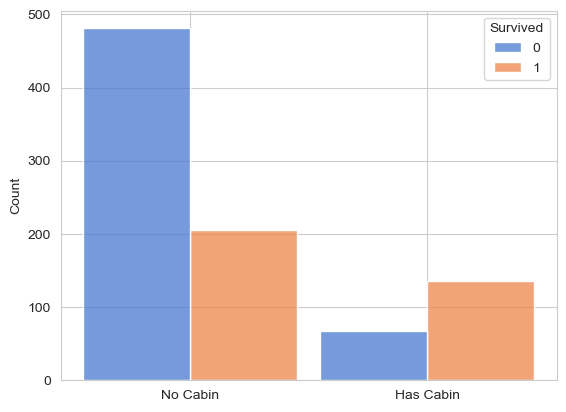

In [22]:
ax = sb.histplot(data=train, x="Has Cabin", **args_discrete)
ax.set_xticks([0, 1], labels=["No Cabin","Has Cabin"])
ax.get_xaxis().set_label_text("")
plt.show()

Just having a cabin seems to put up your chance of survival.

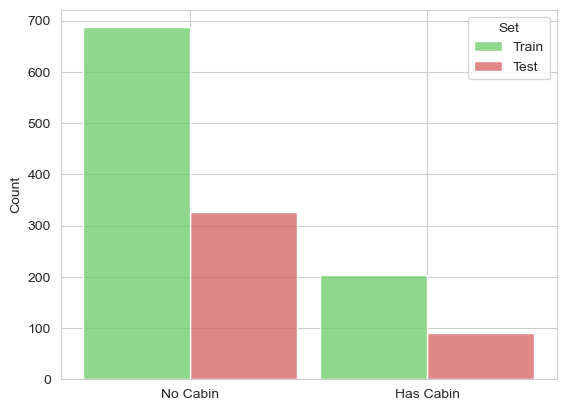

In [23]:
ax = sb.histplot(data=join(train, test), x="Has Cabin", **args_joined)
ax.set_xticks([0, 1], labels=["No Cabin","Has Cabin"])
ax.get_xaxis().set_label_text("")
plt.show()

## Deck

What do the cabin names look like?

In [24]:
train["Cabin"].dropna().head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

Seems that cabin name is made up of alphabetical deck symbol (i.e. A, B, C,...) and a room number. Some people seem to have multiple room numbers.
We will take the deck of each passenger and create a new column.

In [25]:
deck = [x[0] if x is not np.nan else pd.NA for x in train["Cabin"]]
train["Deck"] = deck
deck_test = [x[0] if x is not np.nan else pd.NA for x in test["Cabin"]]
test["Deck"] = deck_test

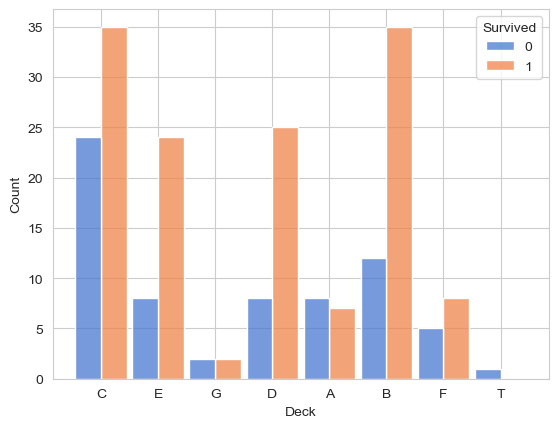

In [26]:
sb.histplot(data=train, x="Deck", **args_discrete)
plt.show()

Some decks fared considerbaly worse than others. Could be due to position of deck within the ship? Or perhaps socioeconomic reasons?

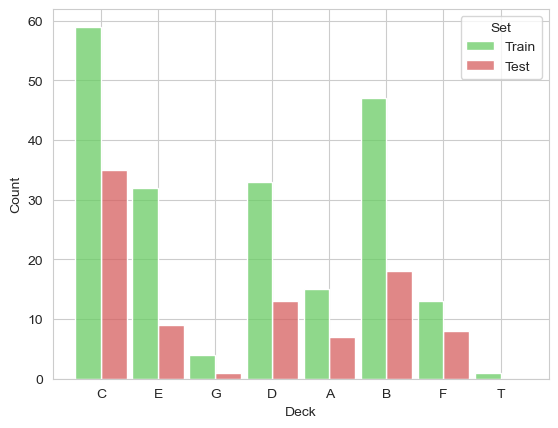

In [27]:
sb.histplot(data=join(train, test), x="Deck", **args_joined)
plt.show()

## Room Number

Can see that some pasengers have multiple rooms. Let's see how many of them.

In [28]:
has_cabin_idxs = train["Has Cabin"] == 1
multiple_cabin_idxs = [
    idx
    for idx, x in (train[has_cabin_idxs]["Cabin"]).items()
    if len(y := x.split()) > 1
]
train.iloc[multiple_cabin_idxs].groupby("Cabin")[
    ["PassengerId", "Name", "SibSp", "Parch"]
].apply(lambda x: x)

PassengerId  \
Cabin                              
B51 B53 B55     679          680   
                872          873   
B57 B59 B63 B66 311          312   
                742          743   
B58 B60         118          119   
                299          300   
B82 B84         789          790   
B96 B98         390          391   
                435          436   
                763          764   
                802          803   
C22 C26         297          298   
                305          306   
                498          499   
C23 C25 C27     27            28   
                88            89   
                341          342   
                438          439   
C62 C64         700          701   
D10 D12         97            98   
F E69           128          129   
F G63           699          700   
F G73           75            76   
                715          716   

                                                                  Name  SibSp  \
Cabin                                                                           
B51 B53 B55     679                 Cardeza, Mr. Thomas Drake Martinez      0   
                872                           Carlsson, Mr. Frans Olof      0   
B57 B59 B63 B66 311                         Ryerson, Miss. Emily Borie      2   
                742              Ryerson, Miss. Susan Parker "Suzette"      2   
B58 B60         118                           Baxter, Mr. Quigg Edmond      0   
                299    Baxter, Mrs. James (Helene DeLaudeniere Chaput)      0   
B82 B84         789                           Guggenheim, Mr. Benjamin      0   
B96 B98         390                         Carter, Mr. William Ernest      1   
                435                          Carter, Miss. Lucile Polk      1   
                763          Carter, Mrs. William Ernest (Lucile Polk)      1   
                802                Carter, Master. William Thornton II      1   
C22 C26         297                       Allison, Miss. Helen Loraine      1   
                305                     Allison, Master. Hudson Trevor      1   
                498    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)      1   
C23 C25 C27     27                      Fortune, Mr. Charles Alexander      3   
                88                          Fortune, Miss. Mabel Helen      3   
                341                     Fortune, Miss. Alice Elizabeth      3   
                438                                  Fortune, Mr. Mark      1   
C62 C64         700  Astor, Mrs. John Jacob (Madeleine Talmadge Force)      1   
D10 D12         97                     Greenfield, Mr. William Bertram      0   
F E69           128                                  Peter, Miss. Anna      1   
F G63           699           Humblen, Mr. Adolf Mathias Nicolai Olsen      0   
F G73           75                             Moen, Mr. Sigurd Hansen      0   
                715         Soholt, Mr. Peter Andreas Lauritz Andersen      0   

                     Parch  
Cabin                       
B51 B53 B55     679      1  
                872      0  
B57 B59 B63 B66 311      2  
                742      2  
B58 B60         118      1  
                299      1  
B82 B84         789      0  
B96 B98         390      2  
                435      2  
                763      2  
                802      2  
C22 C26         297      2  
                305      2  
                498      2  
C23 C25 C27     27       2  
                88       2  
                341      2  
                438      4  
C62 C64         700      0  
D10 D12         97       1  
F E69           128      1  
F G63           699      0  
F G73           75       0  
                715      0

Most multiple cabin entries are associated with multpile passengers. These passengers often share surnames and according to ```SibSp``` and ```Parch``` column have other family members on board. Concievably, these passengers are sharing rooms with their family members.

I wasn't sure how to interpret entries ```F <Deck><room number>``` (e.g. Passenger ID 76 with 'F G63'). In the end I had to resort to checking the [deckplan of the ship](https://www.encyclopedia-titanica.org/titanic-deckplans/f-deck.html). I hope this isn't cheating! This reveals that, in fact, these cabin entries are in fact one single cabin. The deck is indeed the F-deck, which is further split up into G and E sections.  

If we want to use room number as a feature, it will be easiest to pick the room number at random for those passengers with multiple cabins. The justification is that, from our knowledge, we have no reason to believe that when the ship began to sink they were more likely to be in one of those rooms than the other. In any case, the rooms are very close together.

In [29]:
def get_room(x):
    """
    Get the room number from Cabin entry

    Parameters
    ----------

    x : str or missing entry

    Returns
    -------

    room number : int
    """
    # if missing cabin or cabin doesn't have
    # a room number return NaN
    if x is (np.nan or None or pd.NA) or x.isalpha():
        return pd.NA

    rooms = x.split()

    # Check for multiple entries
    if len(rooms) > 1:
        # if its of the type 'F G63' then just return the nuber
        # at the end of the string.
        if rooms[0].isalpha():
            room_no = int(rooms[1][1:])
        else:
            room = np.random.choice(rooms)
            room_no = int(room[1:])
    else:
        room_no = int(rooms[0][1:])
    return room_no

In [30]:
rooms = [get_room(x) for x in train["Cabin"]]
train["Room No."] = rooms
no_room_idxs = train["Room No."].isna()

In [31]:
rooms_test = [get_room(x) for x in test["Cabin"]]
test["Room No."] = rooms_test

<Axes: xlabel='Room No.', ylabel='Density'>

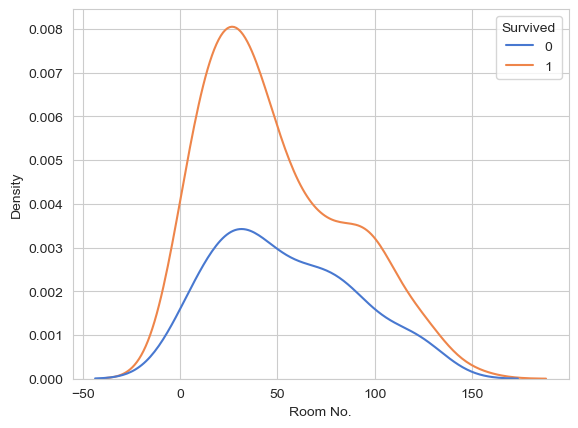

In [32]:
sb.kdeplot(data=train, x="Room No.", **args_kde)

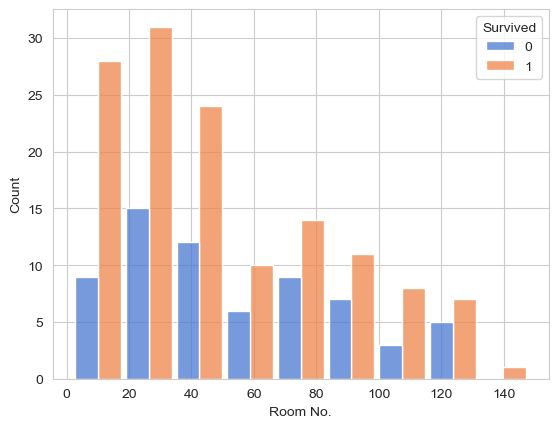

In [33]:
sb.histplot(data=train, x="Room No.", **args)
plt.show()

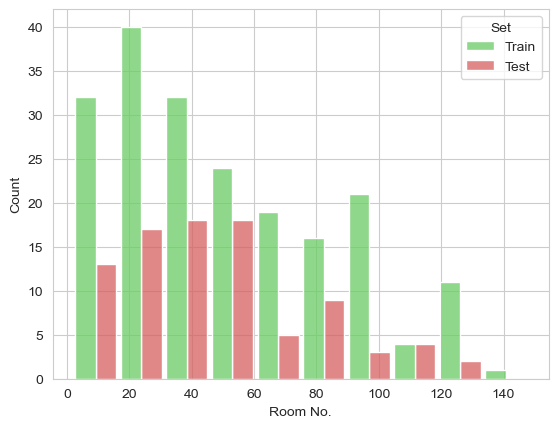

In [34]:
args_joined2 = {"hue":"Set", "multiple":"dodge", "shrink":0.9, "palette":color_set2}
sb.histplot(data=join(train, test), x="Room No.", **args_joined2)
plt.show()

Looks like maybe higher room numbers have a higher survival rate? Maybe beacuse of position in the ship or maybe a socioeconomic thing? Let's plot "Fare" with "Room No."

<Axes: xlabel='Fare', ylabel='Room No.'>

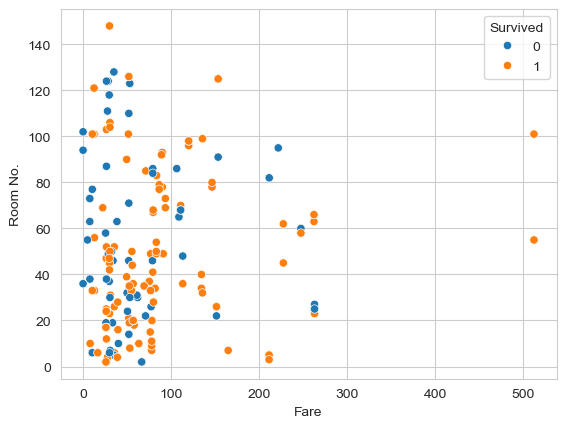

In [35]:
sb.scatterplot(data=train, x="Fare", y="Room No.", hue="Survived")

What about even and odd rooms? I think odd rooms and even rooms are on opposite sides on a ship? So maybe one side has a higher survival rate?

In [36]:
is_even = train["Room No."].dropna() % 2 == 0
is_even_test = test["Room No."].dropna() % 2 == 0
train["Even Room"] = is_even
test["Even Room"] = is_even_test

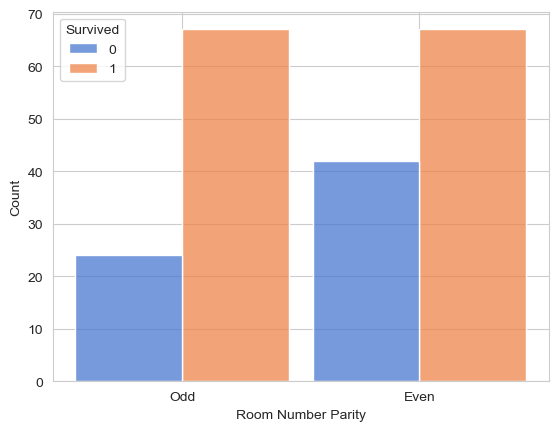

In [37]:
ax = sb.histplot(data=train,x="Even Room", **args_discrete)
ax.set_xticks([0, 1], labels=["Odd", "Even"])
ax.get_xaxis().set_label_text("Room Number Parity")
plt.show()

Does look like even rooms have a higher survival rate! Could be a coincidence but we'll include it in the model.

## Siblings

In [38]:
print("Missing values: ", train["SibSp"].isna().sum())
print("Unique values: ", test["SibSp"].dropna().unique())
print(train["SibSp"].describe())

Missing values:  0
Unique values:  [0 1 2 3 4 5 8]
count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


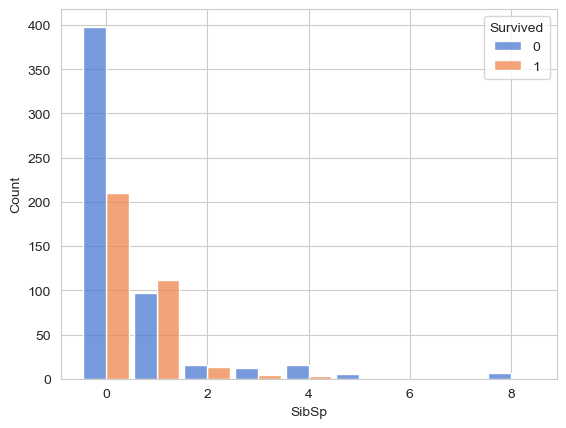

In [39]:
sb.histplot(data=train, x="SibSp", **args_discrete)
plt.show()

<Axes: xlabel='SibSp', ylabel='Survival Rate'>

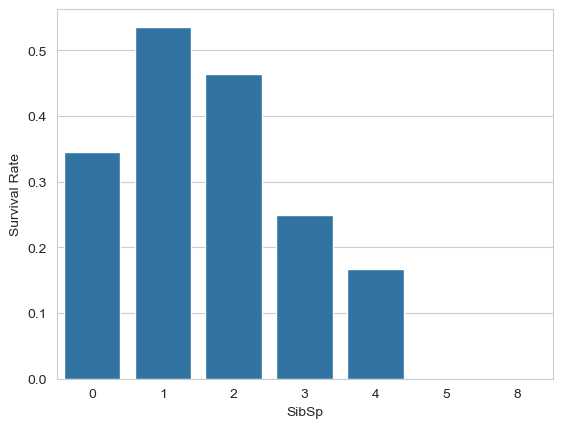

In [40]:
sb.barplot(
    train.groupby(["SibSp"])["Survived"]
    .apply(lambda x: sum(x) / len(x))
    .rename("Survival Rate")
)

## Parch

In [41]:
print("Missing values: ", train["Parch"].isna().sum())
print("Unique values: ", test["Parch"].dropna().unique())
print(train["Parch"].describe())

Missing values:  0
Unique values:  [0 1 3 2 4 6 5 9]
count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64


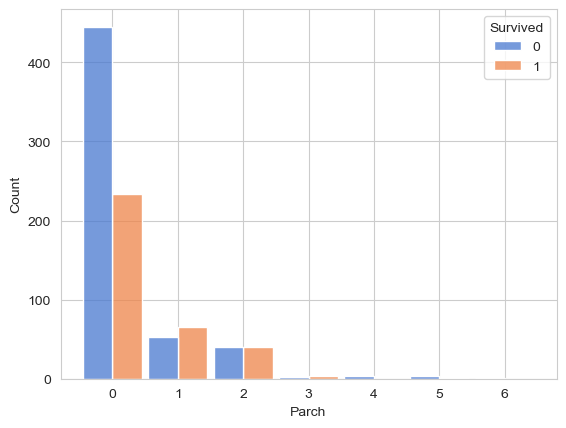

In [42]:
sb.histplot(data=train, x="Parch", **args_discrete)
plt.show()

<Axes: xlabel='Parch', ylabel='Survival Rate'>

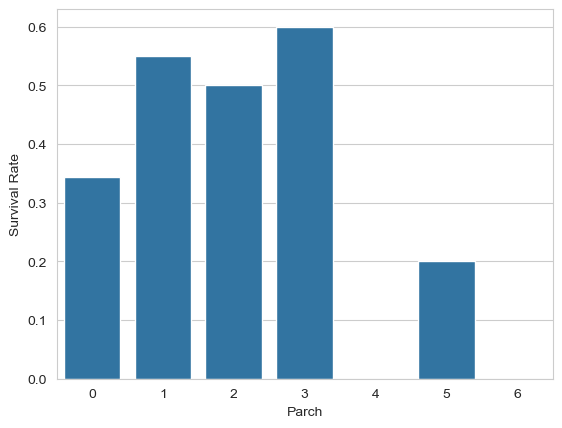

In [43]:
sb.barplot(
    train.groupby(["Parch"])["Survived"]
    .apply(lambda x: sum(x) / len(x))
    .rename("Survival Rate")
)

## Ticket Fare

In [44]:
print("Missing values: ", train["Fare"].isna().sum())
print("No. of Unique values: ", len(test["Fare"].dropna().unique()))
print(train["Fare"].describe())

Missing values:  0
No. of Unique values:  169
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


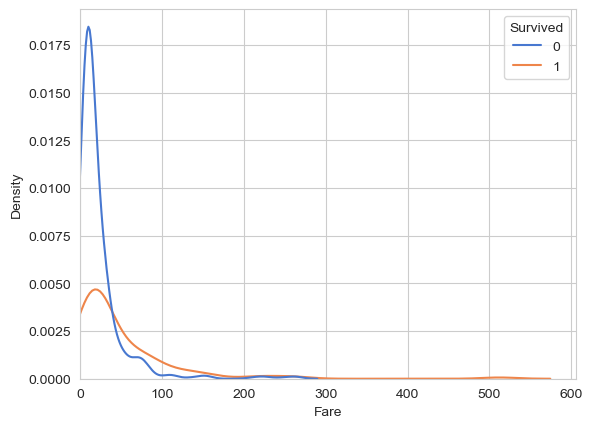

In [45]:
sb.kdeplot(data=train, x="Fare", **args_kde).set(xlim=(0))
plt.show()

## Ticket

In [46]:
print("Missing values: ", train["Ticket"].isna().sum())
print(train["Ticket"].describe())

Missing values:  0
count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object


In [47]:
train["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

Tickets seem to be made up of a alphanumeric prefix e.g. "STON/O2." and a purely numeric ticket number  at the end. We will do some regex to extract the two pieces.

In [48]:
def get_ticket_prefix(string):
    pattern = r"(.*) \d+$"
    try:
        g = re.search(pattern, string)
        return g.group(1)
    except AttributeError:
        return pd.NA

In [49]:
def get_ticket_number(string):
    pattern = r"(\d+)$"
    try:
        g = re.search(pattern, string)
        return int(g.group(1))
    except AttributeError:
        return pd.NA

Get all the prefixes and numbers (if they are present)

In [50]:
ticket_prefixes = [get_ticket_prefix(x) for x in train["Ticket"]]
ticket_numbers = [get_ticket_number(x) for x in train["Ticket"]]
train["Ticket Prefix"] = ticket_prefixes
train["Ticket Number"] = ticket_numbers

Let's do the same for the test data set

In [51]:
test["Ticket Prefix"] = [get_ticket_prefix(x) for x in test["Ticket"]]
test["Ticket Number"] = [get_ticket_number(x) for x in test["Ticket"]]

## Ticket Number

In [52]:
print("Missing values: ", train["Ticket Number"].isna().sum())
print(train["Ticket Number"].describe())

Missing values:  4
count      887
unique     678
top       1601
freq         7
Name: Ticket Number, dtype: int64


How many unique duplicate tickets are there?

In [53]:
duplicate_tickets = [
    ticket_number
    for ticket_number, is_duplicate in (
        train["Ticket Number"].value_counts() > 2
    ).items()
    if is_duplicate
]
duplicate_tickets = list(set(duplicate_tickets))
duplicate_idxs = train["Ticket Number"].isin(duplicate_tickets)
#train[duplicate_idxs].groupby("Ticket Number").apply(lambda x: x)
#train[duplicate_idxs].groupby("Ticket Number")['Surname'].apply(lambda x: len(x.unique())==1).describe()

If there is any predictive power in these duplicate tickets themselves, then there is only any point in using them as features if they appear in the test set too. We will check how many of them appear in the test set in the cell below...

In [54]:
feature_tickets = [x for x in duplicate_tickets if test["Ticket Number"].eq(x).any()]

In [55]:
def ticket_mask(ticket):
    if ticket is not pd.NA:
        if ticket in feature_tickets:
            return ticket
        else: 
            return 0
    else:
        return pd.NA

In [56]:
train["Common Ticket Number"] = [ticket_mask(x) for x in train["Ticket Number"]]
test["Common Ticket Number"] = [ticket_mask(x) for x in test["Ticket Number"]]

In [57]:
ticket_counts = (
    pd.concat([train["Ticket Number"], test["Ticket Number"]]).value_counts().to_dict()
)
train["Ticket Multiplicity"] = train["Ticket Number"].apply(
    lambda x: ticket_counts[x] if x is not pd.NA else pd.NA
)
test["Ticket Multiplicity"] = test["Ticket Number"].apply(
    lambda x: ticket_counts[x] if x is not pd.NA else pd.NA
)

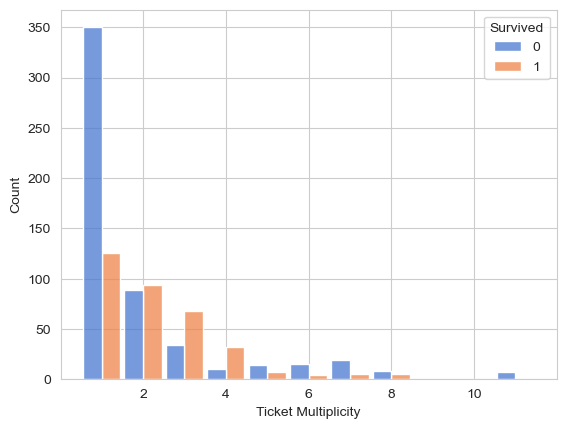

In [58]:
sb.histplot(data=train, x="Ticket Multiplicity", **args_discrete)
plt.show()

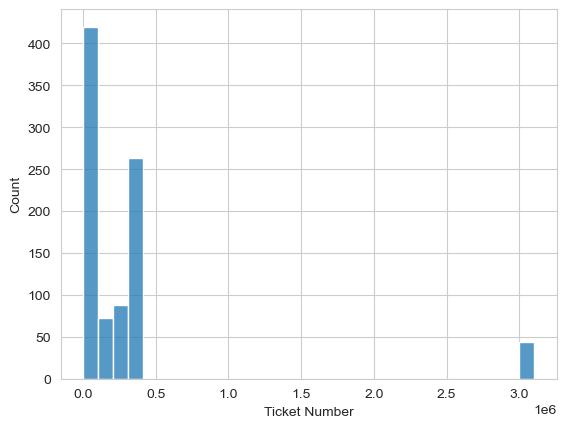

In [59]:
sb.histplot(data=train, x="Ticket Number", bins=30)
plt.show()

Hard to see whats going on with the gap in ticket numbers. Let's look at the lower ticket numbers

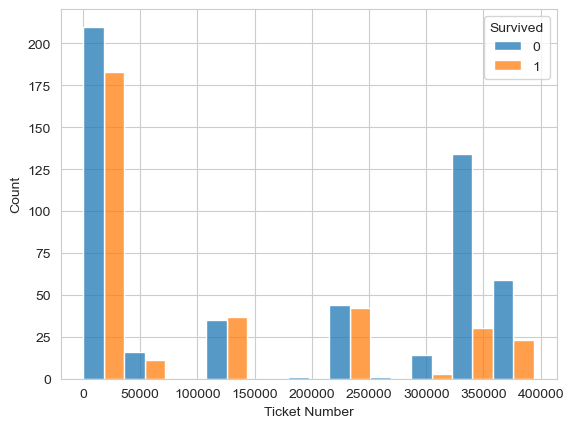

In [60]:
max_idxs = train["Ticket Number"] > 1.0 * 10**6
sb.histplot(data=train[~max_idxs], x="Ticket Number", hue="Survived", multiple="dodge")
plt.show()

And then the higher ticket numbers...

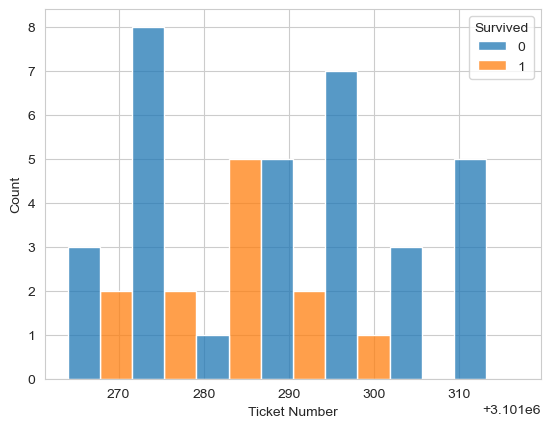

In [61]:
sb.histplot(data=train[max_idxs], x="Ticket Number", hue="Survived", multiple="dodge")
plt.show()

Is there any correlation with ticket price?

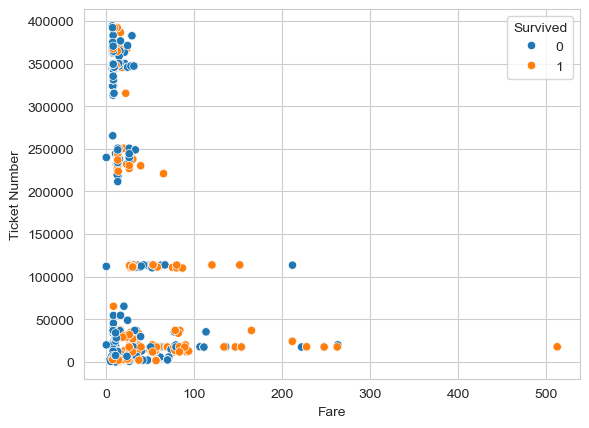

In [62]:
sb.scatterplot(data=train[~max_idxs], x="Fare", y="Ticket Number", hue="Survived")
plt.show()

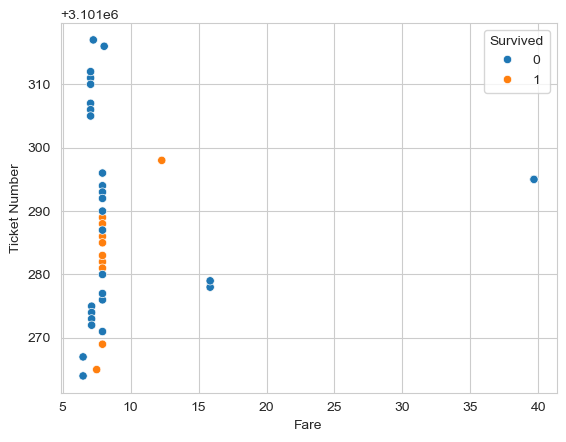

In [101]:
sb.scatterplot(data=train[max_idxs], x="Fare", y="Ticket Number", hue="Survived")
plt.show()

The plots above suggest ticket number as a numeric feature will ot be very useful.

Was interested if anything more can be gleaned from ticket number. I don't understand how ticket numbers are generated so we will see if some simple characteristic like the number of digits has any relevance.

In [64]:
ticket_number_lengths = [
    len(str(x)) if x is not pd.NA else pd.NA for x in train["Ticket Number"]
]
# has_ticket_prefix = [1 if isinstance(x, str) else 0 for x in ticket_prefixes]
train["Ticket Number Length"] = ticket_number_lengths

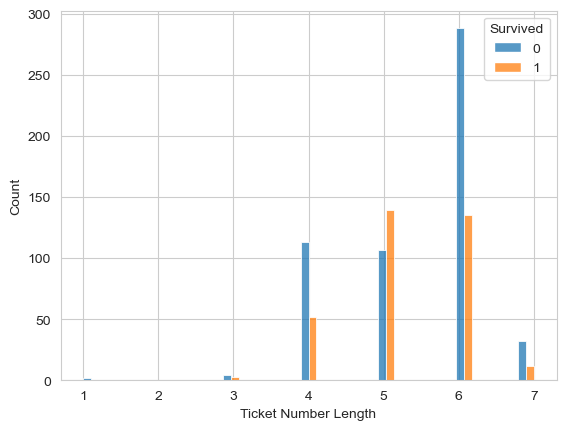

In [65]:
sb.histplot(data=train, x="Ticket Number Length", hue="Survived", multiple="dodge")
plt.show()

It does look like 5-digit ticket numbers have a much better survival rate. However, looking at the bivariate distribution with ticket class (cell below), it seems that this can be explained by the high proportion of first class ticket holders.

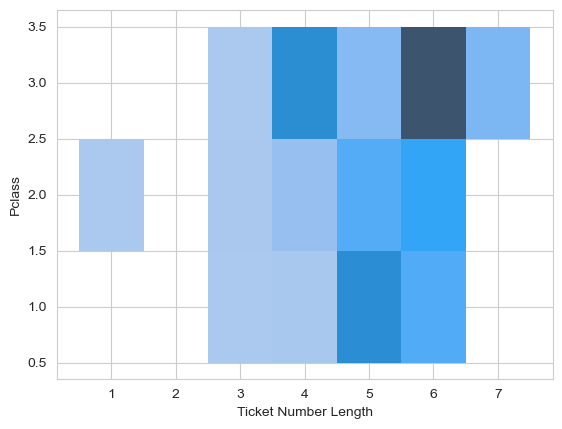

In [66]:
sb.histplot(data=train, x="Ticket Number Length", y="Pclass", discrete=True)
plt.show()

### Ticket Prefix

In [67]:
print("Missing values: ", train["Ticket Prefix"].isna().sum())
train["Ticket Prefix"].describe()

Missing values:  665


count     226
unique     43
top        PC
freq       60
Name: Ticket Prefix, dtype: object

In [68]:
train["Ticket Prefix"].dropna().head()

0          A/5
1           PC
2     STON/O2.
10          PP
12        A/5.
Name: Ticket Prefix, dtype: object

In [69]:
train["Ticket Prefix"].dropna().unique()

array(['A/5', 'PC', 'STON/O2.', 'PP', 'A/5.', 'C.A.', 'A./5.', 'SC/Paris',
       'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C', 'W./C.',
       'SOTON/OQ', 'W.E.P.', 'STON/O 2.', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'SC/AH Basle',
       'A/4', 'WE/P', 'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2',
       'S.C./PARIS', 'C.A./SOTON'], dtype=object)

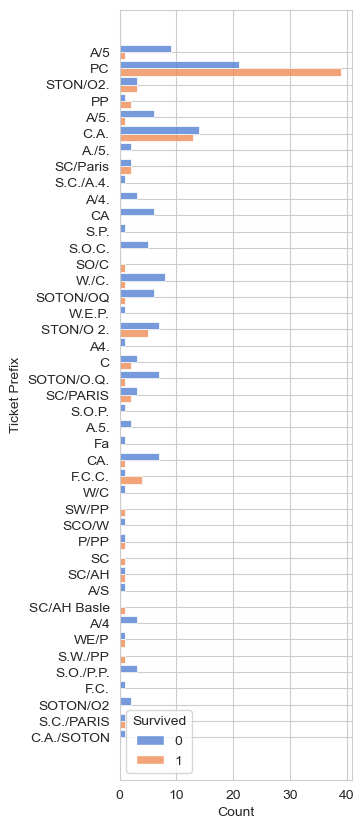

In [70]:
plt.figure(figsize=(3, 10))
sb.histplot(data=train, y="Ticket Prefix", **args_discrete)
plt.show()

Ticket Prefixes seem to be really complicated - 43 different unique prefixes. Although it looks like some of them are just variations on the same string. For example 'A/5.'  probably has the same meaning as 'A/5'. Even so, it doesn't look worth pursuing this as a feature of the model.

In [71]:
train[train["Ticket Prefix"] == "PC"]["Pclass"].value_counts()

Pclass
1    60
Name: count, dtype: int64

## Name

In [72]:
print("Missing values: ", train["Name"].isna().sum())

Missing values:  0


### Surnames

We will extract the surnames from each passenger. This is simply everything that occurs before the comma in the string.

In [73]:
surnames = train["Name"].apply(lambda x: x.split(",")[0])
train["Surname"] = surnames
test["Surname"] = test["Name"].apply(lambda x: x.split(",")[0])

In [74]:
train["Surname"].describe()

count           891
unique          667
top       Andersson
freq              9
Name: Surname, dtype: object

In [75]:
test["Surname"].describe()

count        418
unique       352
top       Davies
freq           4
Name: Surname, dtype: object

Clearly there are a lot of multiple counts for some surnames. 

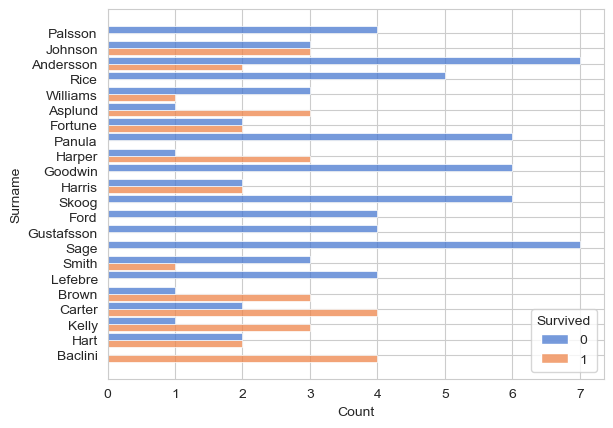

In [76]:
top_surnames = [surname for surname, is_top in 
                (train["Surname"].value_counts() > 3).items() if is_top]

top_surname_idxs = [idx for idx, surname in train["Surname"].items()
                    if surname in top_surnames]

sb.histplot(data=train.iloc[top_surname_idxs], y="Surname", **args_discrete)
plt.show()

Let us look at the passengers with the most common surname "Andersson". We know from "SibSp" and "Parch" columns that its likely that 7 of these people are a family unit.  Looking at other columns it looks like "Andersson, Miss. Erna Alexandra" and "Andersson, Mr. August Edvard ("Wennerstrom")" are not related to the other Anderssons. It looks like everyone in the Andersson family perished. Even though it doesn't guarantee that you are in the same family, and even though being in the same family doesn't guarantee that you all have the same fate, sharing a surname could be a good feature to include. 

In [77]:
train[train["Surname"] == "Andersson"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Has Cabin,Deck,Room No.,Even Room,Ticket Prefix,Ticket Number,Common Ticket Number,Ticket Multiplicity,Ticket Number Length,Surname
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,...,0,<NA>,<NA>,NaN,<NA>,347082,0,7,6,Andersson
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,...,0,<NA>,<NA>,NaN,<NA>,3101281,0,1,7,Andersson
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,...,0,<NA>,<NA>,NaN,<NA>,347082,0,7,6,Andersson
146,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,...,0,<NA>,<NA>,NaN,<NA>,350043,0,1,6,Andersson
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,...,0,<NA>,<NA>,NaN,<NA>,347082,0,7,6,Andersson
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,...,0,<NA>,<NA>,NaN,<NA>,347082,0,7,6,Andersson
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,...,0,<NA>,<NA>,NaN,<NA>,347082,0,7,6,Andersson
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,...,0,<NA>,<NA>,NaN,<NA>,347082,0,7,6,Andersson
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,...,0,<NA>,<NA>,NaN,<NA>,347082,0,7,6,Andersson


In [78]:
train[train["Surname"] == "Johnson"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Has Cabin,Deck,Room No.,Even Room,Ticket Prefix,Ticket Number,Common Ticket Number,Ticket Multiplicity,Ticket Number Length,Surname
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,...,0,<NA>,<NA>,NaN,<NA>,347742,0,3,6,Johnson
172,173,1,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,...,0,<NA>,<NA>,NaN,<NA>,347742,0,3,6,Johnson
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,...,0,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,Johnson
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,...,0,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,Johnson
719,720,0,3,"Johnson, Mr. Malkolm Joackim",male,33.0,0,0,347062,7.7750,...,0,<NA>,<NA>,NaN,<NA>,347062,0,1,6,Johnson
869,870,1,3,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,...,0,<NA>,<NA>,NaN,<NA>,347742,0,3,6,Johnson


Looking at more common surnames, and again looking at ```SibSp``` and ```Parch``` see that those people who in all likelihood are in the same family, have the same ticket number.

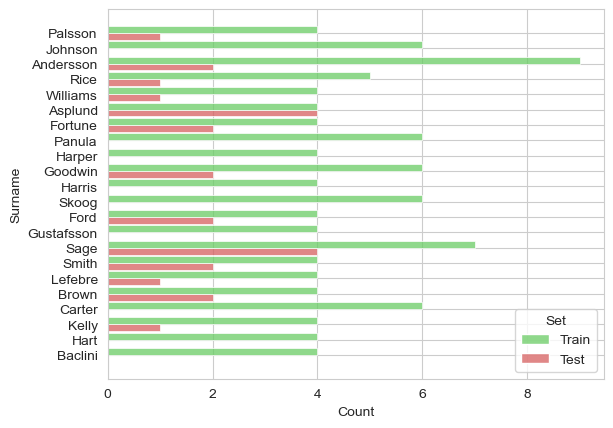

In [79]:
top_surname_idxs_test = [idx for idx, surname in test["Surname"].items()
                    if surname in top_surnames]

sb.histplot(data=join(train.iloc[top_surname_idxs],test.iloc[top_surname_idxs_test]), y="Surname", **args_joined)
plt.show()

Above, we see the counts of the most popular surnames as appearing in the training and test datasets

### Family

From analysis above, it suggests that a combination of surname and ticket number would give a good indication of being in the same family. Let's create a new data column for this:

In [80]:
train["Family"] = train["Ticket Number"].apply(lambda x: str(x)) + train["Surname"]
test["Family"] = test["Ticket Number"].apply(lambda x: str(x)) + test["Surname"]

We will get the indices of the family names that appear at least two times in the training dataset.

In [81]:
family_counts = train["Family"].value_counts() > 2
families = [x for x, idx in family_counts.items() if idx]
family_idxs = train["Family"].isin(families)

As with the ticket number, there's only any point in using the family names itself as a feature, if it appears in the test dataset too. Let's see which family names appear in the test datset.

In [82]:
family_test_counts = [
    (family, y) for family in families if (y := (test["Family"] == family).sum())
]
df = pd.DataFrame(family_test_counts, columns=["Family", "Counts"])
print(df)

           Family  Counts
0        2343Sage       4
1     2144Goodwin       2
2      382652Rice       1
3    19950Fortune       2
4   347077Asplund       3
5   349909Palsson       1
6     4133Lefebre       1
7        6608Ford       1
8       34651West       1
9     2123Laroche       1
10  113781Allison       1


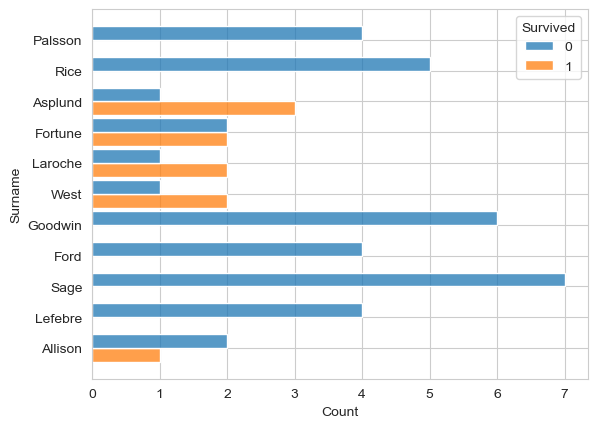

In [83]:
family_idxs = [idx for idx, family in train["Family"].items() if family in df.values]
sb.histplot(
    data=train.iloc[family_idxs],
    y="Surname",
    hue="Survived",
    multiple="dodge",
    shrink=0.9,
)
plt.show()

After a bit of thought, I realised there's probably not any more information that isn't already included in the "Ticket Number" feature. So probably no need to consider surname.

### Titles

Every passenger seems to have a title (i.e. "Mrs." or "Mr."). The titles are recognised by the sub-string of the "Name" that appears after the comma and finshes with a full stop. We wil use regular expressions to extract the title based on this observation.

In [84]:
titles = [y.group(1) if (y := re.search(r"\,\s([\w | \s]+\.)", string))
          is not None else pd.NA for string in train["Name"]]
titles_test = [y.group(1) if (y := re.search(r"\,\s([\w | \s]+\.)", string)) 
               is not None else pd.NA for string in test["Name"]]

In [85]:
train["Title"] = titles
test["Title"] = titles_test

In [86]:
title_counts = (train.groupby("Title")["Survived"].value_counts()
                .reset_index(name="count"))

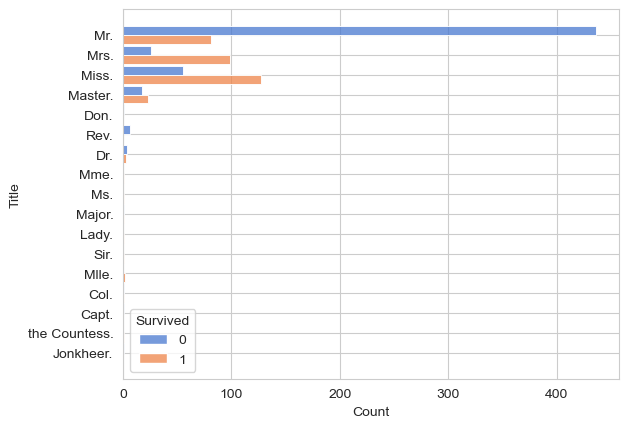

In [87]:
sb.histplot(data=train, y="Title", **args_discrete)
plt.show()
# sb.countplot(titanic["Title"][~survived_idxs])

In [88]:
common_titles = ["Miss.", "Mrs.", "Mr.", "Master."]
common_train_idxs = train["Title"].apply(lambda x: x in common_titles)
common_test_idxs = test["Title"].apply(lambda x: x in common_titles)

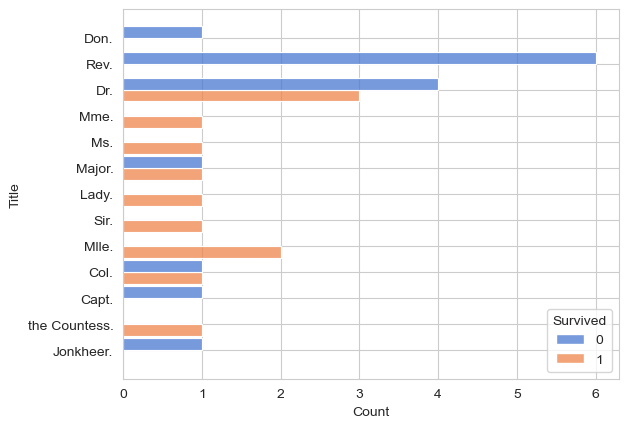

In [89]:
sb.histplot(data=train[~common_train_idxs], y="Title", **args_discrete)
plt.show()

Many titles have only a couple of counts. We can't make any assesment on their predictive power with such a small sample size.

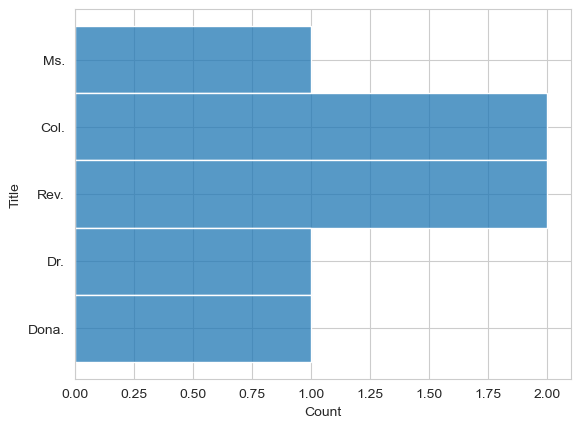

In [90]:
sb.histplot(data=test[~common_test_idxs], y="Title")
plt.show()

In fact, many of these titles don't appear in the test traning set. therefore, definitely shoudln't be included.

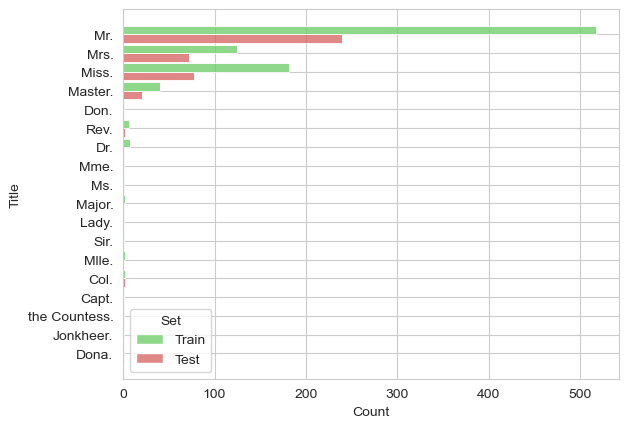

In [91]:
sb.histplot(data=join(train, test), y="Title", **args_joined)
plt.show()

I am going to only include as categories the titles that have a count three or greater in the training set. All other titles will be aggregated in the "Misc." for  miscellaneous title category.

In [92]:
title_counts = train["Title"].value_counts().reset_index(name="count")
misc_list = (title_counts[title_counts["count"] < 3]["Title"]).to_list()
new_titles_train = ["Misc." if x in misc_list else x for x in train["Title"]]
new_titles_test = ["Misc." if x in misc_list else x for x in test["Title"]]

In [93]:
train["Common Title"] = new_titles_train
test["Common Title"] = new_titles_test

These are the titles that will fall under the "Misc." category:

In [94]:
print(misc_list)

['Mlle.', 'Major.', 'Col.', 'the Countess.', 'Capt.', 'Ms.', 'Sir.', 'Lady.', 'Mme.', 'Don.', 'Jonkheer.']


## Export

In [95]:
feature_columns =[
                 'PassengerId',
                 'Survived',
                 'Pclass',
                 'Sex',
                 'Age',
                 'SibSp',
                 'Parch',
                 'Fare',
                 'Embarked',
                 'Deck',
                 'Has Cabin',
                 'Room No.',
                 'Even Room',
                 'Ticket Multiplicity',
                 'Common Ticket Number',
                 'Common Title']
train_export = train[feature_columns]
test_export = test[filter(lambda x: x != "Survived", feature_columns)]

In [100]:
train_export.to_csv(os.getcwd() + "/data/train_cleaned.csv", index = False)
test_export.to_csv(os.getcwd() + "/data/test_cleaned.csv",  index = False)